In [1]:
#https://www.kaggle.com/code/ehkim9580/spaceship-titanic-eda-ehkim-02212041

import pandas as pd
import missingno
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.utils import resample

# Models

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# Save to df
train = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Text(0.5, 1.0, 'Target distribution')

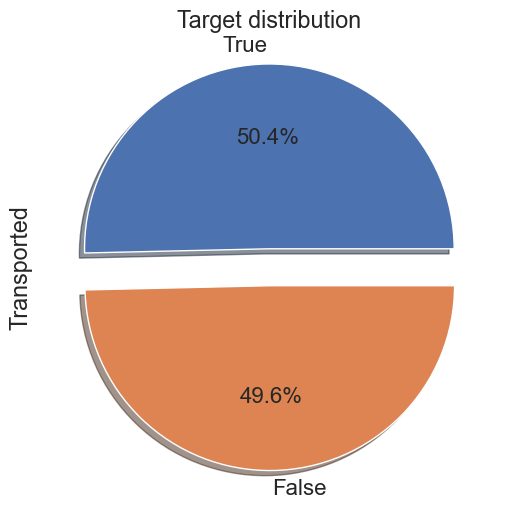

In [6]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

target이 무척 밸런스적절함 - > 고민할 필요 없음

In [11]:
#data type
train.info()
#data type
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

<AxesSubplot:>

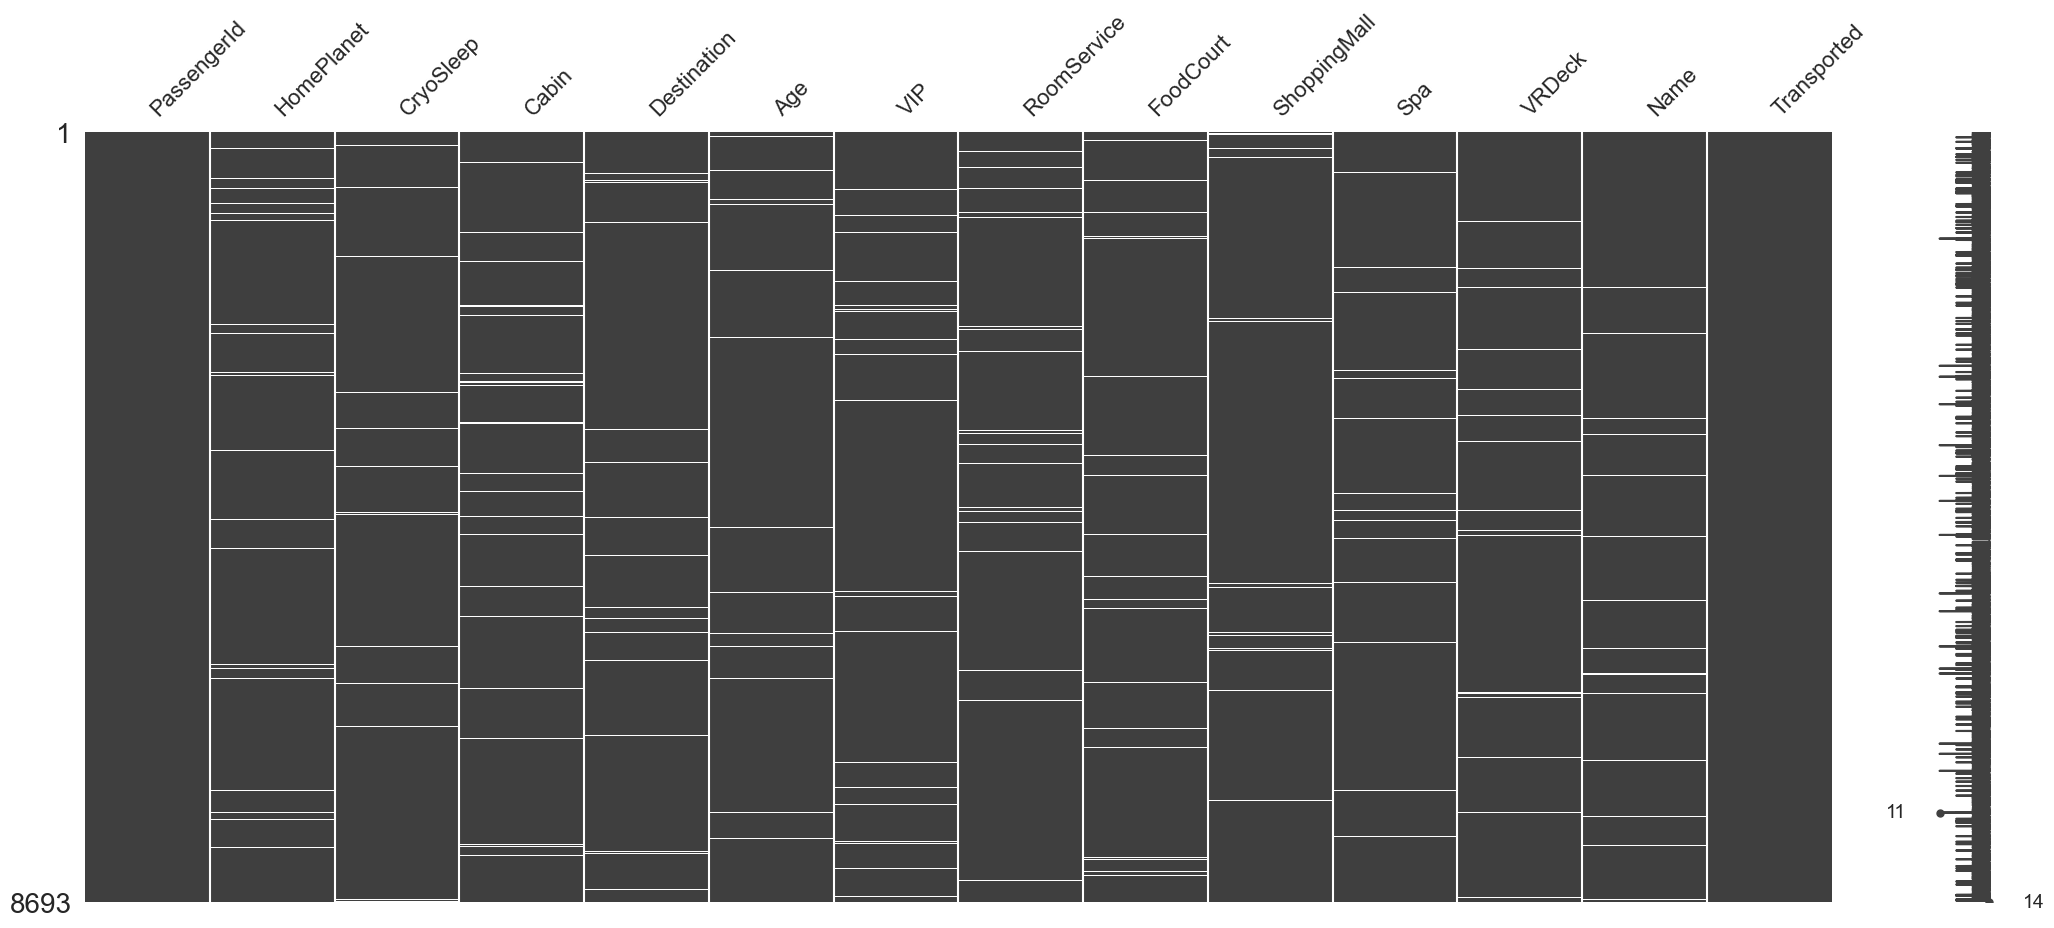

In [9]:

#결측치 확인
missingno.matrix(train)

In [33]:

y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()


data=pd.concat([X, test], axis=0).reset_index(drop=True)

na_cols=data.columns[data.isna().any()].tolist() #결측값이 있는 칼럼들의 이름을 na_cols에 저장

mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv


,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Cabin,299,2.31
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19


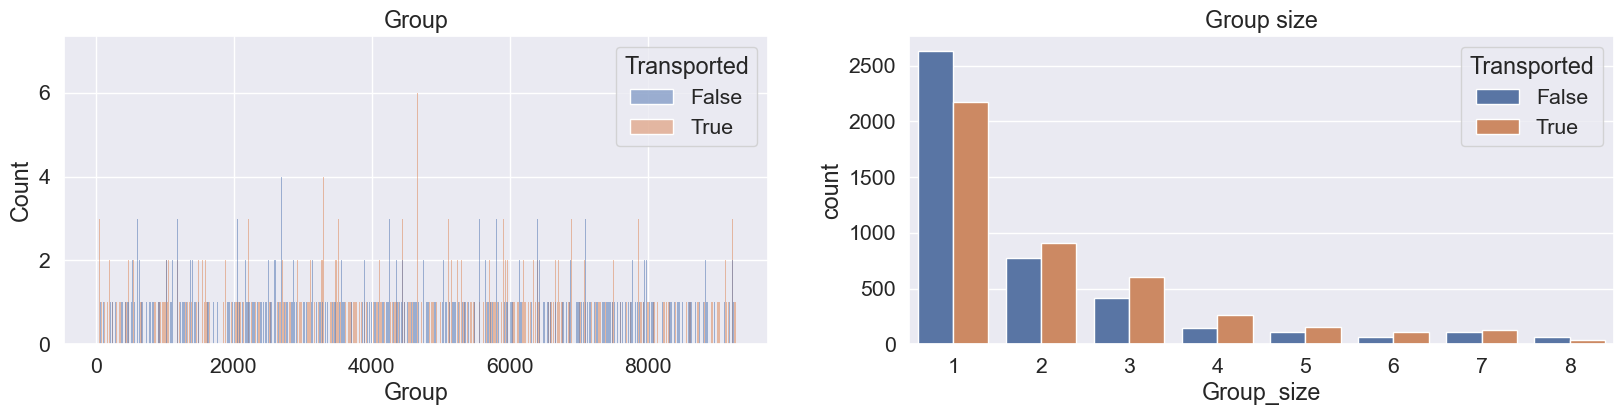

In [30]:
# New feature - Group # id 에서 _ 앞에 오는 숫자
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()


(0.0, 3000.0)

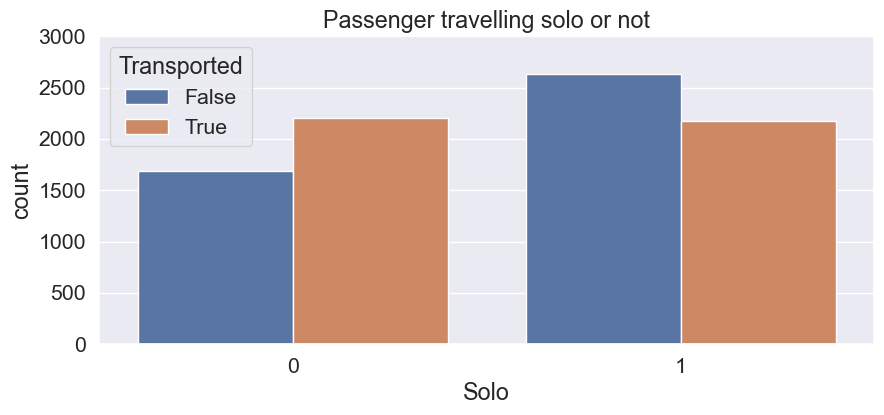

In [22]:
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)


plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

Text(0.5, 1.0, 'Family size')

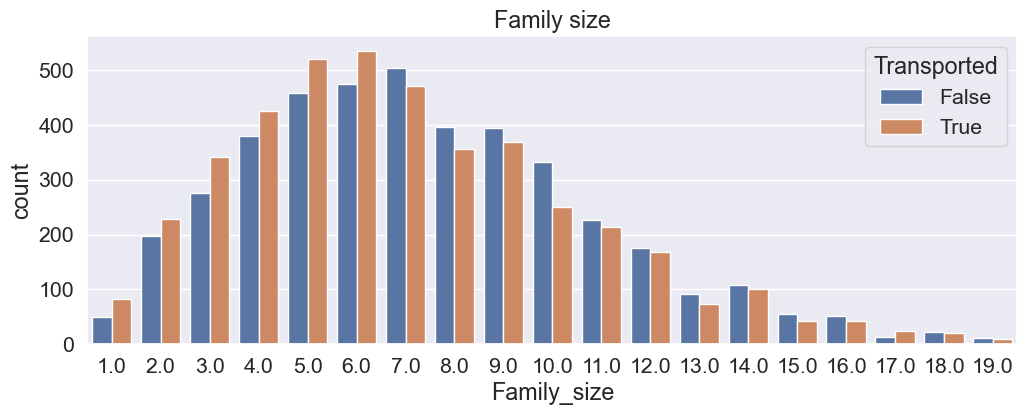

In [56]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

In [64]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist() #결측값이 있는 칼럼들의 이름을 na_cols에 저장

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Cabin,299,2.31
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19



# 0 Homeplanet

In [42]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head(10)

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,2.0,0.0,0.0
7,1.0,0.0,0.0
8,0.0,3.0,0.0
9,0.0,0.0,1.0


In [ ]:
#주의 : 하나의 그룹에 여러명이 있을수있음 ex group 3 -> 2명 모두 europa

Text(0.5, 1.0, 'Number of unique home planets per group')

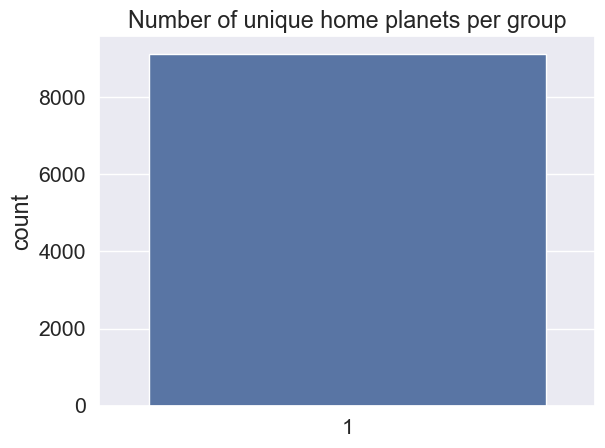

In [35]:
# Countplot of unique values #
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')

고향과 group은 일치하는 데이터임 - > 결측치를 group에 따라 처리할 수 있다.

In [50]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum() #고향이 결측치인 갯수

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index  #HomePlanet 컬럼이 결측치인 승객 중, 그룹 내에서 다른 HomePlanet이 적어도 하나 존재하는 그룹을 갖는 승객의 인덱스

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 157


HomePlanet 컬럼이 결측치인 승객 중, 그룹 내에서 다른 HomePlanet이 적어도 하나 존재하는 그룹의 경우
해당그룹의 존재하는 승객의 고향을 따옴 -> 결측치가 많이 줄어들었다.

<AxesSubplot:xlabel='Cabin', ylabel='HomePlanet'>

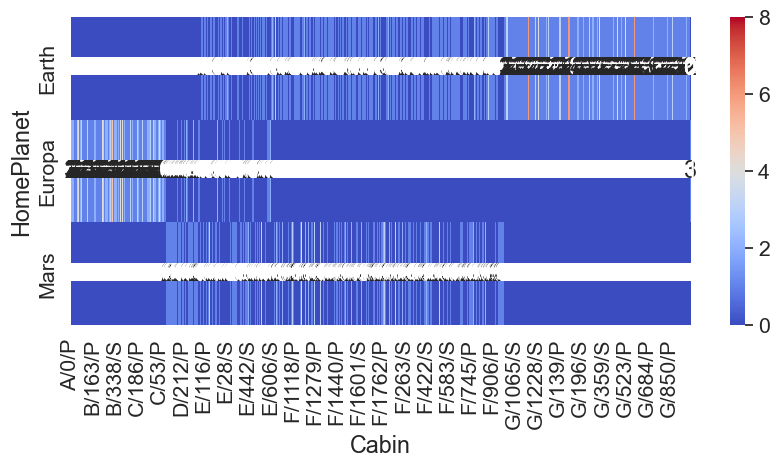

In [52]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [54]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 157


Text(0.5, 1.0, 'Number of unique planets per surname')

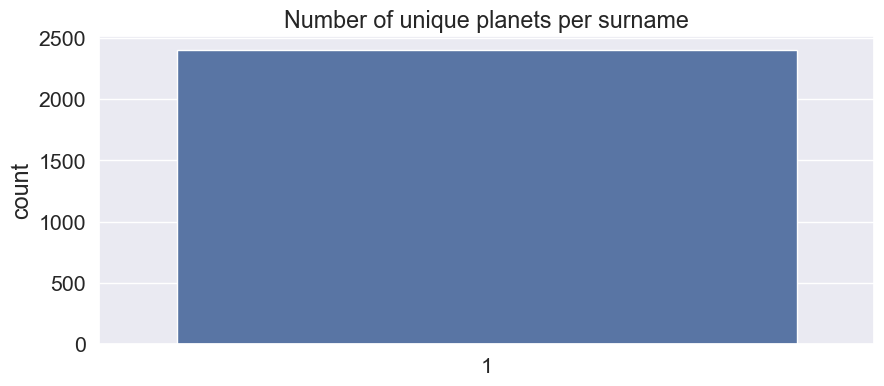

In [65]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

같은 성이면 같은 행성

In [66]:

HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 17


In [68]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
234,0251_01,NaN,55 Cancri e
807,0853_01,NaN,55 Cancri e
1855,1978_01,NaN,TRAPPIST-1e
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
7211,7703_02,NaN,TRAPPIST-1e
8613,9194_01,NaN,55 Cancri e


대부분이 TRAPPIST-1e를 향하므로 이를 살펴보자.

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

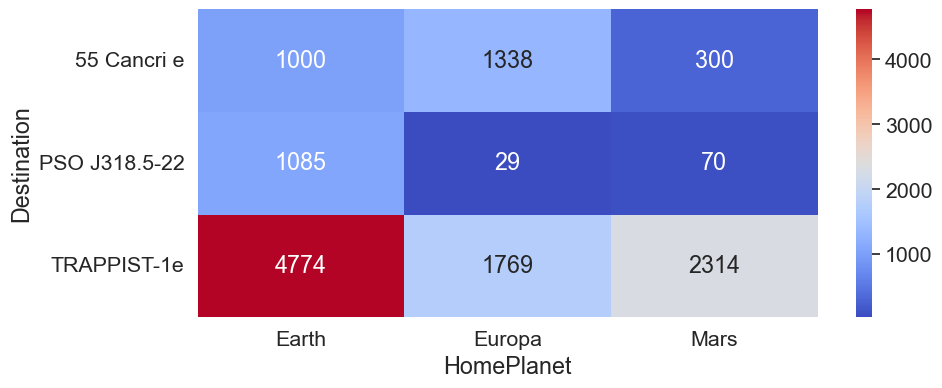

In [69]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [71]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 17
#HomePlanet missing values after: 0


Text(0.5, 1.0, 'Number of unique surnames by group')

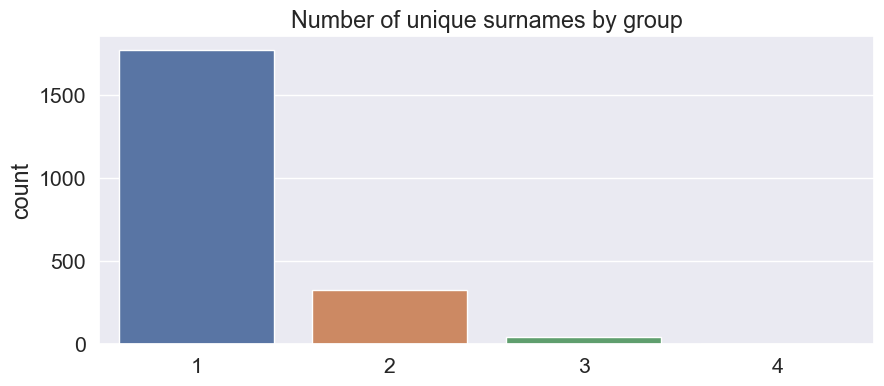

In [72]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

In [73]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


# 1 AGE

Text(0.5, 1.0, 'Age group distribution')

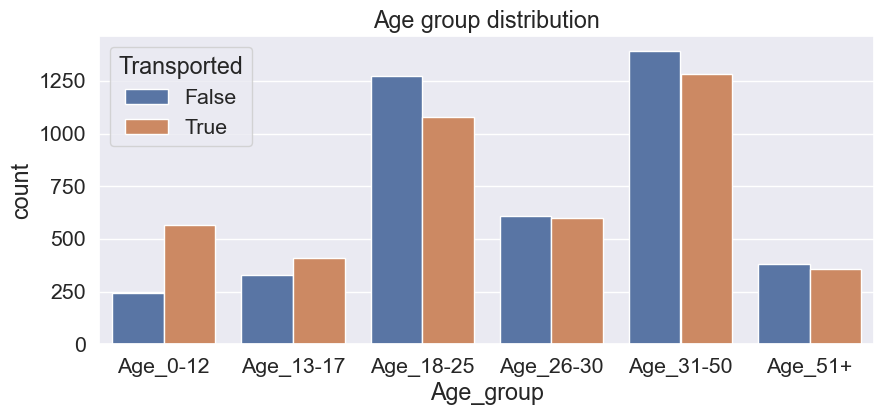

In [12]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

In [13]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

NameError: name 'exp_feats' is not defined

# EXPENDITURE (NEW FEATURES)

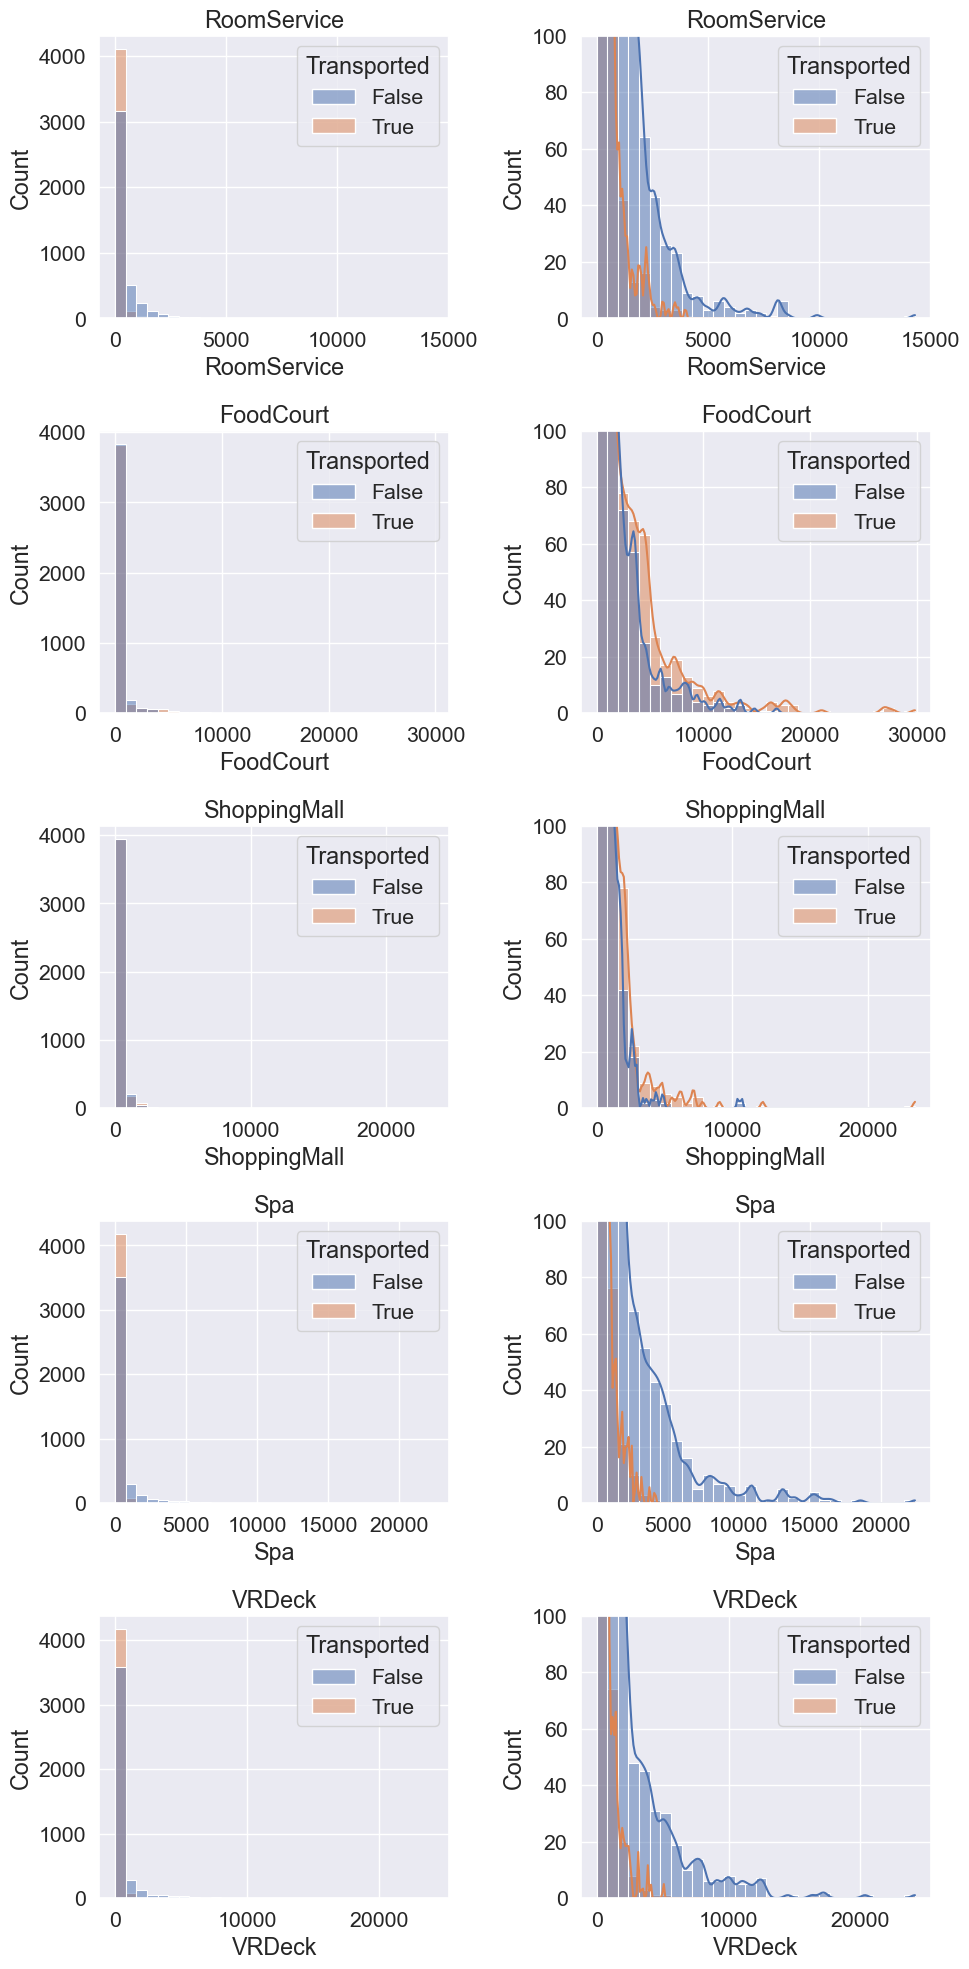

In [14]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

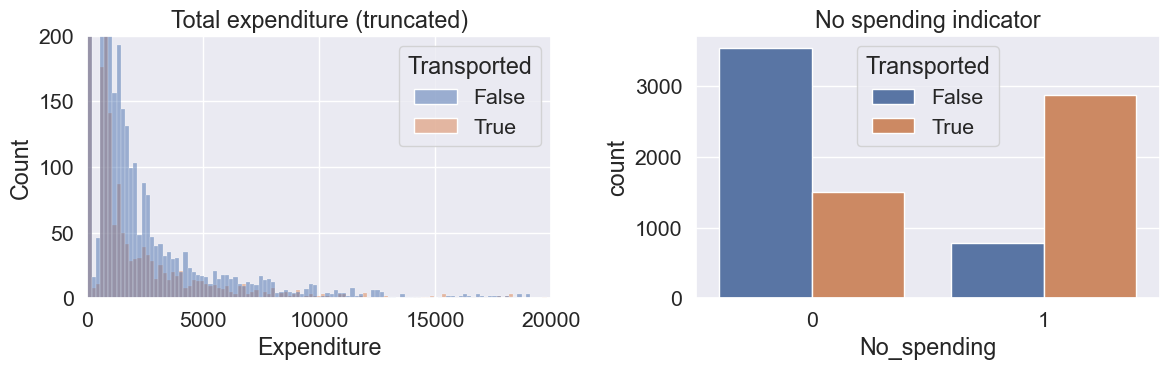

In [15]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()